In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from audioDataLoader import audioDataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
batch_size = 100
train_data = audioDataloader(index_file="/data/khood/GitHub/MLAudio/dataset_15sec/train/train.csv")
valid_data = audioDataloader(index_file="/data/khood/GitHub/MLAudio/dataset_15sec/valid/valid.csv")
test_data = audioDataloader(index_file="/data/khood/GitHub/MLAudio/dataset_15sec/test/test.csv")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

STD

$ \sigma={\sqrt {\frac {\sum(x_{i}-{\mu})^{2}}{N}}} $

$\sigma$	= 	population standard deviation \
$N$	= 	the size of the population \
$x_i$	= 	each value from the population \
$\mu$	= 	the population mean 

In [4]:
# mean = 0.
# std = 0.
# nb_samples = 0.
# for data, _ in train_loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples
# for data, _ in valid_loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples
# for data, _ in test_loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples
# print(f"Total number of samples: {nb_samples}")
# print(f"mean: {mean}")
# print(f"std: {std}")

Total number of samples: 60000.0 \
mean: tensor([2.3009]) \
std: tensor([42.1936]) \
March 13

In [5]:
train_data = audioDataloader(index_file="/data/khood/GitHub/MLAudio/dataset_15sec/train/train.csv") 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
inputs, labels = next(iter(train_loader))

In [6]:
transforms.Normalize(mean=[2.3009], std=[42.1936])(inputs)

tensor([[[[ 1.0243e-03, -5.4339e-02, -5.1213e-02,  ...,  2.6153e+00,
            1.4164e+00, -5.3637e-02],
          [-4.0620e-02,  6.9448e-03, -2.8004e-02,  ...,  4.2247e-01,
            5.6605e-01, -3.6513e-02],
          [-5.3337e-02, -9.9394e-03,  3.7176e-02,  ...,  8.6846e-02,
            1.0798e-02, -1.7445e-02],
          ...,
          [-5.4523e-02, -5.4532e-02, -5.4532e-02,  ..., -5.4532e-02,
           -5.4532e-02, -5.4526e-02],
          [-5.4523e-02, -5.4532e-02, -5.4532e-02,  ..., -5.4532e-02,
           -5.4532e-02, -5.4525e-02],
          [-5.4522e-02, -5.4532e-02, -5.4532e-02,  ..., -5.4532e-02,
           -5.4532e-02, -5.4526e-02]]],


        [[[-3.8470e-02, -5.4351e-02, -5.4508e-02,  ...,  5.4834e-02,
            1.6219e-02,  2.1650e+00],
          [-4.9837e-02, -5.4393e-02, -5.4048e-02,  ...,  5.3029e+00,
            7.6796e+00,  7.6049e-01],
          [-4.6975e-02, -5.1469e-02, -5.1289e-02,  ...,  5.0631e+01,
            5.6535e+01,  2.5616e+01],
          ...,
   

In [7]:
data_transform = transforms.Compose([
    transforms.Normalize(mean=[2.3009], std=[42.1936])  # Normalize the pixel values
])
batch_size = 15
train_data = audioDataloader(index_file="/data/khood/GitHub/MLAudio/dataset_15sec/train/train.csv", transforms=data_transform)
valid_data = audioDataloader(index_file="/data/khood/GitHub/MLAudio/dataset_15sec/valid/valid.csv", transforms=data_transform)
test_data = audioDataloader(index_file="/data/khood/GitHub/MLAudio/dataset_15sec/test/test.csv", transforms=data_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
inputs, labels = next(iter(train_loader))

In [9]:
len(train_loader)

2667

In [10]:
int(7201/32)

225

In [11]:
inputs.shape

torch.Size([15, 1, 201, 7201])

In [12]:
labels.shape

torch.Size([15, 1])

In [13]:
labels

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])

In [14]:
int(201/225)

0

In [15]:
inputs[0]

tensor([[[-0.0545,  0.7024,  0.6377,  ...,  6.1308,  4.4057,  3.2850],
         [-0.0302,  0.6637,  1.0070,  ...,  9.6166,  4.3334,  1.0736],
         [ 0.3287,  0.1641,  0.1911,  ...,  4.2173,  0.3582,  0.2131],
         ...,
         [-0.0544, -0.0545, -0.0545,  ..., -0.0545, -0.0545, -0.0544],
         [-0.0544, -0.0545, -0.0545,  ..., -0.0545, -0.0545, -0.0544],
         [-0.0543, -0.0545, -0.0545,  ..., -0.0545, -0.0545, -0.0544]]])

In [16]:
inputs[0].shape

torch.Size([1, 201, 7201])

In [17]:
labels[0]

tensor([0.])

In [18]:
nn.AvgPool2d((1, 32), stride=(1, 32))(inputs[0]).shape

torch.Size([1, 201, 225])

In [19]:
labels[1]

tensor([0.])

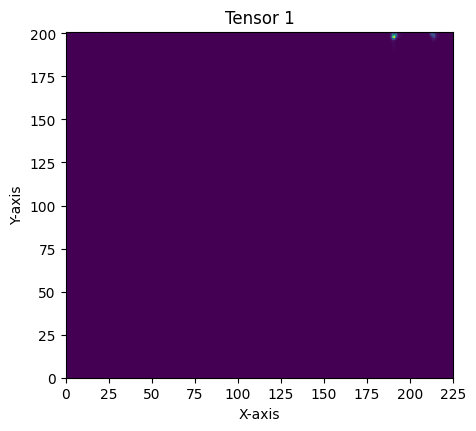

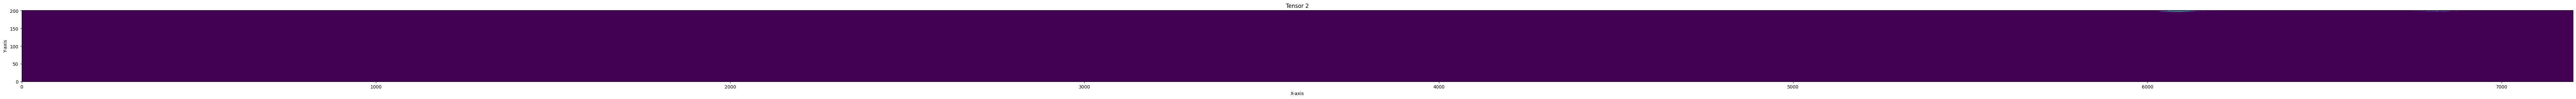

In [20]:
avgPooling = nn.AvgPool2d((1, 32), stride=(1, 32))(inputs[1]).squeeze(0)
og = inputs[1].squeeze(0)

array_to_plot_1 = avgPooling.numpy()
array_to_plot_2 = og.numpy()

# Create figure for Tensor 1
fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.imshow(array_to_plot_1, cmap='viridis', origin='upper', extent=[0, avgPooling.shape[1], 0, avgPooling.shape[0]])
ax1.set_title('Tensor 1')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')

# Show the first graph
plt.show(fig1)

# Create figure for Tensor 2
fig2, ax2 = plt.subplots(figsize=(100, 100))
ax2.imshow(array_to_plot_2, cmap='viridis', origin='upper', extent=[0, og.shape[1], 0, og.shape[0]])
ax2.set_title('Tensor 2')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')

# Show the second graph
plt.show(fig2)

# ResNet

In [21]:
resnet18 = models.resnet18()
num_classes = 1
resnet18.fc = nn.Sequential(
                            nn.Linear(resnet18.fc.in_features, 1), 
                            nn.Sigmoid())# change to binary classification 
resnet18.conv1 =  nn.Sequential(
                                nn.AvgPool2d((1, 32), stride=(1, 32)),
                                nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                                ) # change input layer to greyscale (for the spectrogram )
loss_function = nn.BCELoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
# optimizer = optim.Adam(resnet18.parameters(), lr=0.1, weight_decay=0.0001)
num_epochs = 2
resnet18.to(device)

ResNet(
  (conv1): Sequential(
    (0): AvgPool2d(kernel_size=(1, 32), stride=(1, 32), padding=0)
    (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-

In [22]:
torch.save(resnet18.state_dict(), "./resnet18.pt")

In [24]:
losses = []
accuracies = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    resnet18.train()
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet18(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            predicted = torch.round(outputs)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            losses.append(loss.item())
            accuracy = correct / total
            accuracies.append(accuracy)
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)

Epoch 0


  0%|          | 0/2667 [00:20<?, ?batch/s, accuracy=20, loss=1.32]   


KeyboardInterrupt: 

In [ ]:
# Evaluate on the test set
resnet18.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

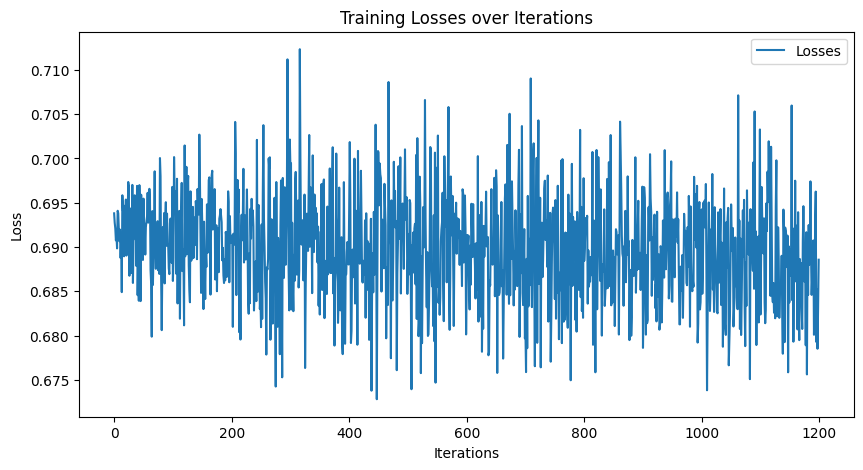

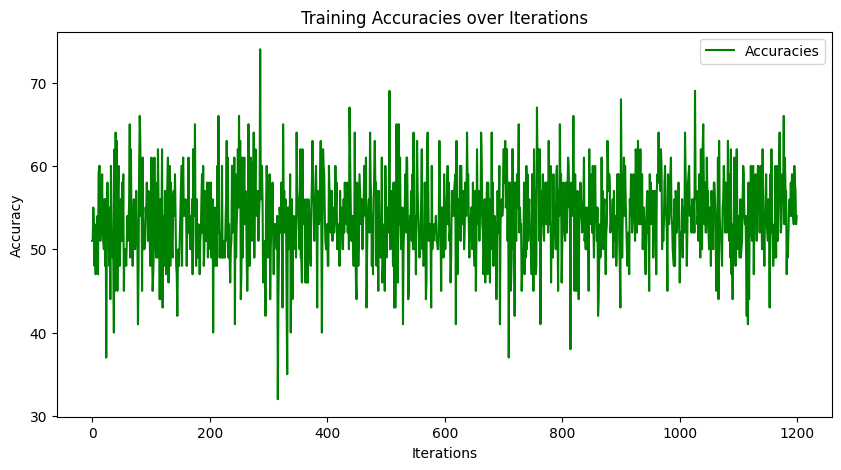

In [5]:
df = pd.read_csv('/data/khood/GitHub/MLAudio/old.train.csv')
plt.figure(figsize=(10, 5))
plt.plot(df['losses'], label='Losses')
plt.title('Training Losses over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(df['accuracies'], label='Accuracies', color='green')
plt.title('Training Accuracies over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()